<a href="https://colab.research.google.com/github/DmtrRm/IAAC2024_tutorials/blob/main/kaggle_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**LIBRARIES IMPORT**

In [26]:
import calendar
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler

**FUNCTIONS THAT WILL BE USED**

In [27]:
def encode_binary_categorical(data_set):
  binary_Lbls=[]
  categor_Lbls=[]

  for c in data_set.columns:

    if len(data_set[c].unique())<=3 and any(x=="Yes" for x in data_set[c].unique()):
      le=LabelEncoder()
      res =le.fit_transform(data_set[c])
      data_set[c]=1-res
      binary_Lbls.append(c)

    elif data_set[c].dtype=="object":
      le=LabelEncoder()
      res =le.fit_transform(data_set[c])
      data_set[c]=res
      categor_Lbls.append(c)

  return categor_Lbls

In [28]:
def find_pair_list(corralation,cor_value):


  pair_list=[]
  x=corralation.shape[0]
  y=corralation.shape[1]

  for i in range(0,x):
    for j in range(0,y):
      if (corralation.iloc[i,j]>=cor_value or corralation.iloc[i,j]<=(-cor_value)) and corralation.iloc[i,j]!=1 :
        pair_list=pair_list+[(sorted([corralation.columns[i], corralation.columns[j]]))]

  groups = []

  for pair in pair_list:
    added_to_group = False
    for group in groups:
      if any(variable in group for variable in pair):
        group.extend(pair)
        group = list(set(group))
        added_to_group = True
        break
    if not added_to_group:
      groups.append(pair)

  result = [list(set(group)) for group in groups]
  return result

**DATA UPLOADING**

In [29]:
metadata = pd.read_csv("/content/DATA/metadata.csv", index_col=0)
meters = pd.read_csv("/content/DATA/meters.csv", index_col=0)
test = pd.read_csv("/content/DATA/test.csv", index_col=0)
train = pd.read_csv("/content/DATA/train.csv", index_col=0)
weather = pd.read_csv("/content/DATA/weather.csv", index_col=0)

**DATA CLEANING**

In [30]:
for c in metadata.columns:
   if len(metadata[c].unique())==1:
    metadata=metadata.drop([c], axis=1)

In [31]:
cLbls_metadata=encode_binary_categorical(metadata)
print(cLbls_metadata)

['site_id', 'primaryspaceusage', 'sub_primaryspaceusage', 'timezone', 'industry', 'subindustry', 'heatingtype', 'rating']


In [32]:
result_metadata=find_pair_list(metadata.corr(),0.9)
print(result_metadata)

[['sqft', 'sqm'], ['timezone', 'lat', 'lng', 'heatingtype']]


In [33]:
columns_to_drop=['sqft','lat','lng','heatingtype']
metadata=metadata.drop(columns=columns_to_drop)

In [34]:
for c in metadata.columns:
    if len(metadata[c].isna().unique())>1:
      print(c,"is corralated with :",metadata.columns[metadata.corr()[c]>0.7])

site_id_kaggle is corralated with : Index(['site_id_kaggle', 'numberoffloors'], dtype='object')
yearbuilt is corralated with : Index(['yearbuilt'], dtype='object')
numberoffloors is corralated with : Index(['site_id', 'site_id_kaggle', 'numberoffloors'], dtype='object')
occupants is corralated with : Index(['sqm', 'occupants'], dtype='object')


In [35]:
for c in metadata.columns:
    if len(metadata[c].isna().unique())>1:
      print(metadata[c].isna().value_counts())
      print("\n")

False    235
True      16
Name: site_id_kaggle, dtype: int64


False    199
True      52
Name: yearbuilt, dtype: int64


False    224
True      27
Name: numberoffloors, dtype: int64


True     138
False    113
Name: occupants, dtype: int64




In [36]:
metadata.head()

,building_id,site_id,site_id_kaggle,primaryspaceusage,sub_primaryspaceusage,sqm,timezone,electricity,hotwater,water,gas,industry,subindustry,yearbuilt,numberoffloors,occupants,rating
136,432,3,143.0,0,2,4703.0,1,1,0,0,0,0,2,NaN,5.0,NaN,8
137,416,3,143.0,0,2,499.3,1,1,1,0,0,0,2,NaN,4.0,NaN,9
138,436,3,143.0,0,2,9061.0,1,1,0,0,0,0,2,2005.0,10.0,NaN,7
139,441,3,143.0,0,3,7579.0,1,1,0,0,0,0,2,1913.0,5.0,NaN,9
140,442,3,143.0,0,3,5295.0,1,1,1,0,0,0,2,1953.0,6.0,NaN,8


In [39]:
cols_to_drop = ["site_id_kaggle","yearbuilt","numberoffloors","occupants"]

for n in cols_to_drop:

  X = metadata.loc[metadata[n].isna()==False].drop(columns=cols_to_drop)
  Y = metadata.loc[metadata[n].isna()==False][n]
  missing_X = metadata.loc[metadata[n].isna()].drop(columns=cols_to_drop)
  tree = DecisionTreeRegressor()
  tree.fit(X, Y)

  zipped = [(x, i) for i,x in sorted(zip(tree.feature_importances_, X), reverse=True)]

  metadata[n].loc[metadata[n].isna()] = tree.predict(missing_X).astype(int)

<ipython-input-39-da975098cff9>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata[n].loc[metadata[n].isna()] = tree.predict(missing_X).astype(int)
<ipython-input-39-da975098cff9>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata[n].loc[metadata[n].isna()] = tree.predict(missing_X).astype(int)
<ipython-input-39-da975098cff9>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata[n].loc[metadata[n].isna()] = tree.pr

In [40]:
metadata.head()

,building_id,site_id,site_id_kaggle,primaryspaceusage,sub_primaryspaceusage,sqm,timezone,electricity,hotwater,water,gas,industry,subindustry,yearbuilt,numberoffloors,occupants,rating
136,432,3,143.0,0,2,4703.0,1,1,0,0,0,0,2,1953.0,5.0,40.0,8
137,416,3,143.0,0,2,499.3,1,1,1,0,0,0,2,1995.0,4.0,10.0,9
138,436,3,143.0,0,2,9061.0,1,1,0,0,0,0,2,2005.0,10.0,525.0,7
139,441,3,143.0,0,3,7579.0,1,1,0,0,0,0,2,1913.0,5.0,525.0,9
140,442,3,143.0,0,3,5295.0,1,1,1,0,0,0,2,1953.0,6.0,264.0,8


<Axes: >

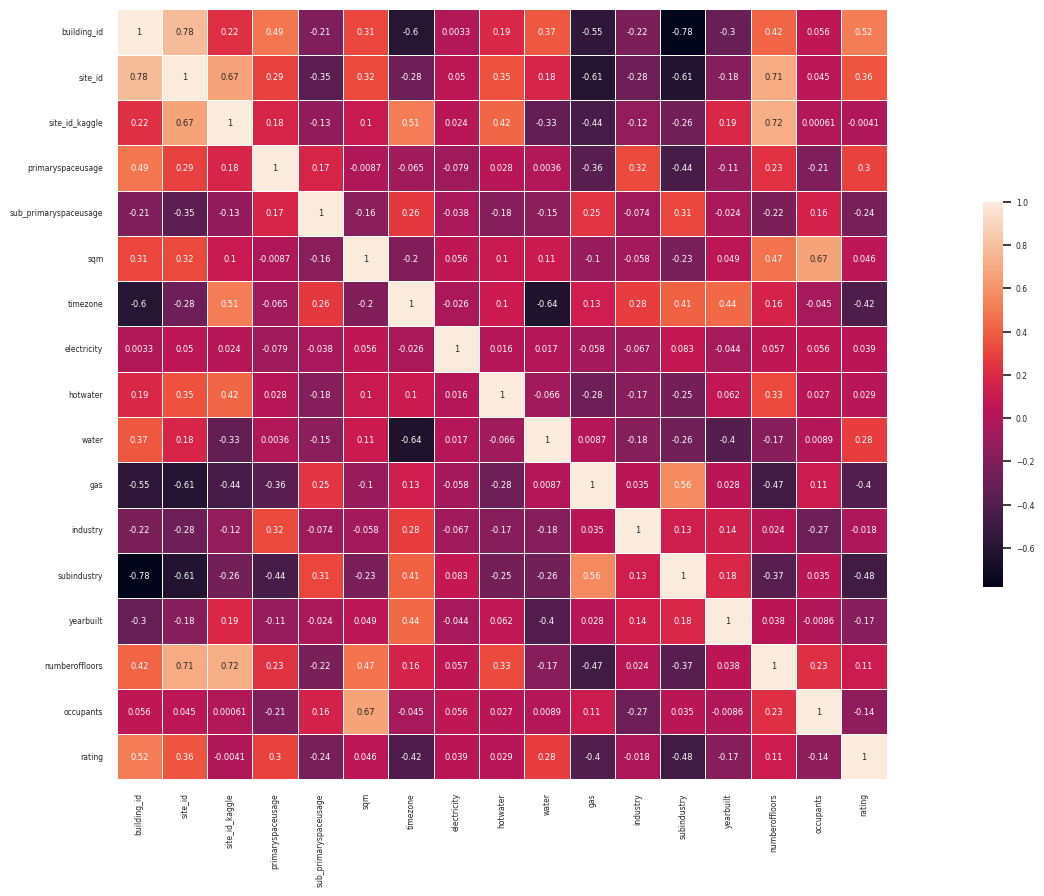

In [41]:
sns.set(font_scale=0.5, rc={'figure.figsize':(25,10)})
sns.heatmap(metadata.corr(),
            # cmap=cmap,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5},
            annot=True)

**DATA MERGING**

In [42]:
full_df = train.merge(metadata, on='building_id', how='left')

In [43]:
full_df.head()

,building_id,day,meter,meter_reading,site_id,site_id_kaggle,primaryspaceusage,sub_primaryspaceusage,sqm,timezone,electricity,hotwater,water,gas,industry,subindustry,yearbuilt,numberoffloors,occupants,rating
0,2,2016-02-02,595,102.6,0,52.0,1,4,811.0,1,1,0,0,1,1,9,1976.0,1.0,0.0,6
1,2,2016-02-02,207,0.3,0,52.0,1,4,811.0,1,1,0,0,1,1,9,1976.0,1.0,0.0,6
2,2,2016-02-03,595,88.8,0,52.0,1,4,811.0,1,1,0,0,1,1,9,1976.0,1.0,0.0,6
3,2,2016-02-03,207,0.1,0,52.0,1,4,811.0,1,1,0,0,1,1,9,1976.0,1.0,0.0,6
4,2,2016-02-04,595,76.3,0,52.0,1,4,811.0,1,1,0,0,1,1,9,1976.0,1.0,0.0,6


In [44]:
full_df["day"] = full_df["day"].apply(lambda s: datetime.strptime(s, "%Y-%m-%d"))
full_df["year"] = full_df["day"].apply(lambda s: s.year)
full_df["month"] = full_df["day"].apply(lambda s: s.month)
full_df["day_number"] = full_df["day"].apply(lambda s: s.day)
full_df["weekday"] = full_df["day"].apply(lambda s: s.weekday() in [5,6])

In [45]:
full_df.head()

,building_id,day,meter,meter_reading,site_id,site_id_kaggle,primaryspaceusage,sub_primaryspaceusage,sqm,timezone,...,industry,subindustry,yearbuilt,numberoffloors,occupants,rating,year,month,day_number,weekday
0,2,2016-02-02,595,102.6,0,52.0,1,4,811.0,1,...,1,9,1976.0,1.0,0.0,6,2016,2,2,False
1,2,2016-02-02,207,0.3,0,52.0,1,4,811.0,1,...,1,9,1976.0,1.0,0.0,6,2016,2,2,False
2,2,2016-02-03,595,88.8,0,52.0,1,4,811.0,1,...,1,9,1976.0,1.0,0.0,6,2016,2,3,False
3,2,2016-02-03,207,0.1,0,52.0,1,4,811.0,1,...,1,9,1976.0,1.0,0.0,6,2016,2,3,False
4,2,2016-02-04,595,76.3,0,52.0,1,4,811.0,1,...,1,9,1976.0,1.0,0.0,6,2016,2,4,False


In [46]:
le = LabelEncoder()
weather["day"] = weather["timestamp"]
weather["day"] = pd.to_datetime(weather["day"])
weather.drop(columns=["timestamp"], inplace=True)

In [48]:
weather.head()

,site_id,airTemperature,cloudCoverage,dewTemperature,precipDepth1HR,precipDepth6HR,seaLvlPressure,windDirection,windSpeed,day
18121,Trapano,11.3,0.9,10.5,NaN,NaN,1024.0,160.5,3.4,2016-02-01 01:00:00
18122,Trapano,12.3,0.6,10.8,NaN,NaN,1023.8,170.8,5.2,2016-02-01 02:00:00
18123,Trapano,12.1,0.6,9.7,NaN,NaN,1022.7,180.2,5.1,2016-02-01 03:00:00
18124,Trapano,12.4,0.7,9.8,NaN,NaN,1021.8,160.1,5.4,2016-02-01 04:00:00
18125,Trapano,11.6,0.5,9.3,NaN,NaN,1021.6,170.1,5.1,2016-02-01 05:00:00


In [47]:
full_df=full_df.merge(weather, how="left", on=["day", "site_id"])

ValueError: You are trying to merge on int64 and object columns. If you wish to proceed you should use pd.concat

**DATA CLEANING**

In [ ]:
cLbls_full_df=encode_binary_categorical(full_df)
print(cLbls_full_df)

['site_id', 'primaryspaceusage', 'sub_primaryspaceusage', 'timezone', 'industry', 'subindustry', 'heatingtype', 'rating']


<ipython-input-91-a8759ef538ba>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(full_df.corr(),


<Axes: >

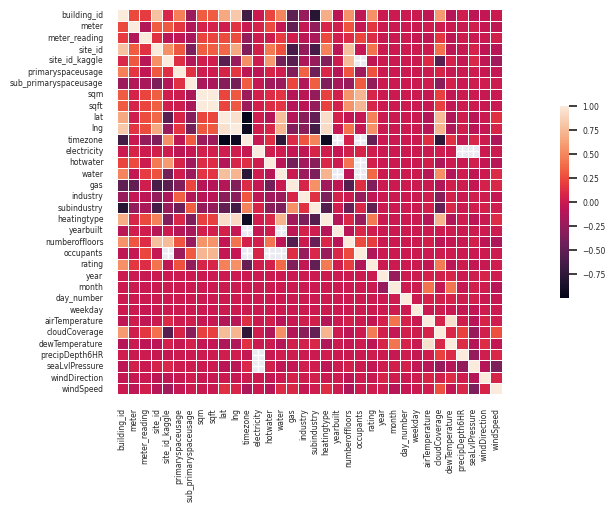

In [ ]:
sns.set(font_scale=0.5, rc={'figure.figsize':(15,5)})
sns.heatmap(full_df.corr(),
            # cmap=cmap,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5},
            annot=False)

In [ ]:
result_full_df=find_pair_list(full_df.corr(),0.9)
print(result_full_df)

<ipython-input-93-368ad845de2f>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  result_full_df=find_pair_list(full_df.corr(),0.9)


[['sqm', 'sqft'], ['lat', 'lng', 'heatingtype', 'timezone'], ['airTemperature', 'dewTemperature']]


In [ ]:
columns_to_drop=['sqft','lat','lng','heatingtype','dewTemperature']
full_df=full_df.drop(columns=columns_to_drop)

<ipython-input-95-98c55d50f691>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(full_df.corr(),


<Axes: >

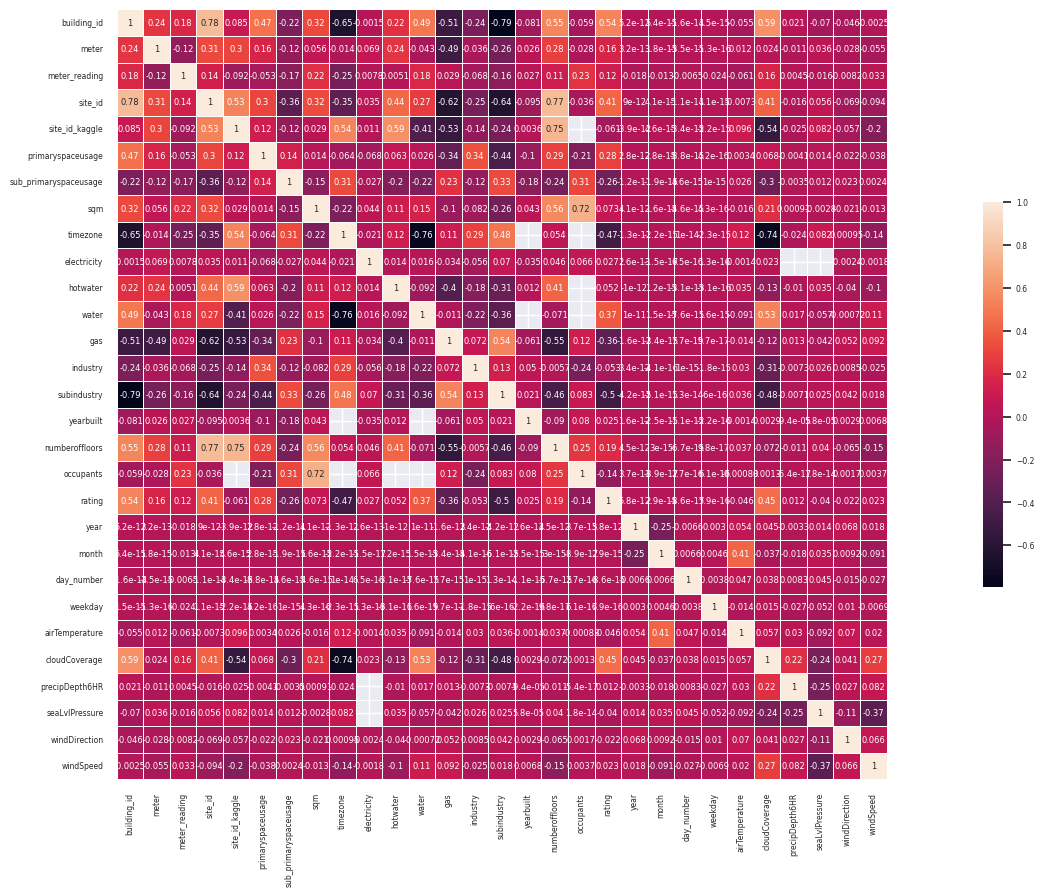

In [ ]:
sns.set(font_scale=0.5, rc={'figure.figsize':(25,10)})
sns.heatmap(full_df.corr(),
            # cmap=cmap,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5},
            annot=True)

In [ ]:
for c in full_df.columns:
    if len(full_df[c].isna().unique())>1:
        print(full_df[c].isna().value_counts())
        print("\n")

False    253526
True      12740
Name: site_id_kaggle, dtype: int64


False    208936
True      57330
Name: yearbuilt, dtype: int64


False    236327
True      29939
Name: numberoffloors, dtype: int64


True     133770
False    132496
Name: occupants, dtype: int64


False    264900
True       1366
Name: airTemperature, dtype: int64


True     146243
False    120023
Name: cloudCoverage, dtype: int64


True     175012
False     91254
Name: precipDepth6HR, dtype: int64


True     169417
False     96849
Name: seaLvlPressure, dtype: int64


False    259070
True       7196
Name: windDirection, dtype: int64


False    265165
True       1101
Name: windSpeed, dtype: int64




In [ ]:
cols_to_drop = ["numberoffloors", "yearbuilt"]

X = full_df.loc[full_df["yearbuilt"].isna()==False].drop(columns=cols_to_drop)
Y = full_df.loc[full_df["yearbuilt"].isna()==False]["yearbuilt"]
missing_X = full_df.loc[full_df["yearbuilt"].isna()].drop(columns=cols_to_drop)

tree = DecisionTreeRegressor()
tree.fit(X, Y)

DTypePromotionError: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>)

In [ ]:
full_df["yearbuilt"].loc[full_df["yearbuilt"].isna()] = tree.predict(missing_X).astype(int)

DTypePromotionError: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>)